<a href="https://colab.research.google.com/github/Pujitha-999/fmml_labs_projects/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [ ]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [ ]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-10 14:53:10--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.112, 18.160.200.71, 18.160.200.77, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   169MB/s    in 0.3s    

2024-05-10 14:53:11 (169 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


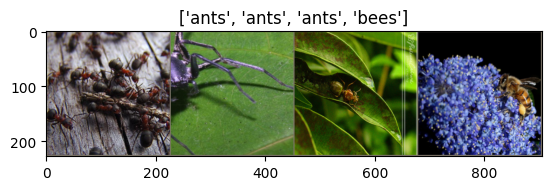

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.0MB/s]


In [ ]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5585 Acc: 0.7213

Epoch 1/4
----------
Loss: 0.3607 Acc: 0.8730

Epoch 2/4
----------
Loss: 0.4131 Acc: 0.8279

Epoch 3/4
----------
Loss: 0.6055 Acc: 0.7623

Epoch 4/4
----------
Loss: 0.5488 Acc: 0.7746



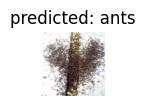

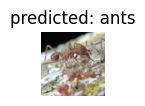

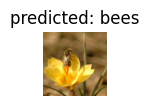

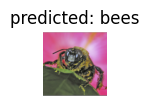

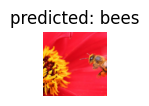

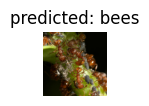

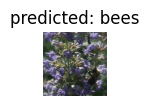

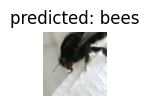

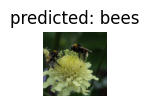

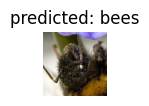

In [ ]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


#*QUESTION-1*

* Data augmentations like resizing, cropping, flipping, rotating, and adding noise to training data serve several significant purposes in machine learning:

1. *Increase Robustness*: By presenting variations of the same data to the model during training, it learns to generalize better. This helps the model become more robust to changes in the input data that it might encounter during inference.

2. *Increase Variability*: Augmentations introduce variability into the training data, which helps prevent overfitting. Overfitting occurs when a model becomes too specialized in learning from the training data and fails to generalize well to unseen data. Augmentations encourage the model to learn the underlying patterns rather than memorizing specific instances.

3. *Enlarge Training Dataset*: By generating augmented versions of the original data, the effective size of the training dataset increases. This can be especially beneficial when the original dataset is small, as it allows the model to learn from a more diverse set of examples.

4. *Data Balancing*: Augmentations can help balance class distributions in imbalanced datasets. By creating augmented versions of minority class samples, the augmented dataset becomes more balanced, which can lead to better model performance, especially for tasks like classification.

5. *Improve Generalization*: Augmentations help the model learn invariant features that are useful for making predictions, regardless of minor variations in the input data. This improves the model's ability to generalize to unseen data.

* Overall, data augmentations are a crucial component of training deep learning models, helping them learn more effectively from limited data and improve their ability to generalize to new situations.*QUESTION-1*

* Data augmentations like resizing, cropping, flipping, rotating, and adding noise to training data serve several significant purposes in machine learning:

1. *Increase Robustness*: By presenting variations of the same data to the model during training, it learns to generalize better. This helps the model become more robust to changes in the input data that it might encounter during inference.

2. *Increase Variability*: Augmentations introduce variability into the training data, which helps prevent overfitting. Overfitting occurs when a model becomes too specialized in learning from the training data and fails to generalize well to unseen data. Augmentations encourage the model to learn the underlying patterns rather than memorizing specific instances.

3. *Enlarge Training Dataset*: By generating augmented versions of the original data, the effective size of the training dataset increases. This can be especially beneficial when the original dataset is small, as it allows the model to learn from a more diverse set of examples.

4. *Data Balancing*: Augmentations can help balance class distributions in imbalanced datasets. By creating augmented versions of minority class samples, the augmented dataset becomes more balanced, which can lead to better model performance, especially for tasks like classification.

5. *Improve Generalization*: Augmentations help the model learn invariant features that are useful for making predictions, regardless of minor variations in the input data. This improves the model's ability to generalize to unseen data.

* Overall, data augmentations are a crucial component of training deep learning models, helping them learn more effectively from limited data and improve their ability to generalize to new situations.

#*QUESTION-2*

* If you don't use a pre-trained ResNet model and instead train it from scratch (i.e., with pretrained=False), the performance of the model might be significantly affected.

* Here are a few potential outcomes:

1. *Lower Performance*: Training a deep neural network from scratch without pre-trained weights often requires a larger dataset and more computational resources. Without the pre-trained weights, the model starts with random initialization, which can make convergence slower and may lead to poorer performance, especially if the dataset is small.

2. *Increased Training Time*: Training a deep neural network from scratch typically requires more iterations of optimization algorithms like gradient descent to converge to a good solution. This increases the training time, as the model needs to learn all the features and patterns from the data.

3. *Potential Overfitting*: Without the regularization effect provided by pre-trained weights, the model might be more prone to overfitting, especially if the dataset is small or noisy. This can lead to poor generalization performance on unseen data.

4. *Dependency on Data Augmentation*: When training from scratch, data augmentation becomes even more crucial to improve generalization and prevent overfitting. Without effective data augmentation strategies, the model may struggle to learn robust features.

* In summary, while training a ResNet model from scratch is possible, it generally requires careful consideration of factors such as dataset size, computational resources, regularization techniques, and effective data augmentation strategies to achieve good performance.

#*QUESTION-3*

* The performance of a pre-trained ResNet model on a task like classifying ants vs. bees images can vary depending on how similar the pre-training dataset is to the target task dataset.

* Here are a few scenarios:

1. *Similar Pre-training Dataset*: If the pre-training dataset is somewhat similar to the ants vs. bees dataset (e.g., it contains images of insects or animals), then the pre-trained ResNet model is likely to capture general features useful for image classification tasks. In this case, fine-tuning the pre-trained model on the ants vs. bees dataset could lead to good performance, as the model has already learned relevant features during pre-training.

2. *Dissimilar Pre-training Dataset*: If the pre-training dataset is significantly different from the ants vs. bees dataset (e.g., it contains images of cars or buildings), the pre-trained ResNet model may not capture features relevant to the target task well. In this case, the performance of the pre-trained model might not be as good, and fine-tuning it on the ants vs. bees dataset may not lead to significant improvements. However, using transfer learning techniques like fine-tuning with a lower learning rate or freezing some layers might still help leverage some of the learned features.

3. *Domain-Specific Pre-training*: In some cases, pre-training on a domain-specific dataset related to the target task (e.g., pre-training on a large dataset of various insects) could lead to better performance compared to pre-training on a more general dataset. If such domain-specific pre-training is available, it's likely to provide more relevant features for the ants vs. bees classification task.

* In summary, while pre-trained models offer a valuable starting point for transfer learning, their performance on a specific task depends on the similarity between the pre-training dataset and the target task dataset.
* Fine-tuning and other transfer learning techniques can help adapt the pre-trained model to the target task domain.